
# Introduction Regression

---

Many advanced machine learning and data analysis techniques are founded on the principles of regression. A solid understanding of regression is often essential for mastering more complex algorithms, such as logistic regression, polynomial regression, Ridge Regression, Lasso, linear kernels in SVM, and neural networks. In this first assignment, we will explore the fundamentals of regression to establish a strong foundation for a wide range of machine learning applications.

This notebook consists the following parts:

- [A: data preparation regression](#01)
- [B: Implementation of the cost function algorithm](#02)
- [C: Implementation of the gradient descent algorithm](#03)
- [D: Implementation of a regularization parameter](#04)
- [E: Data preparation logistic regression](#051)
- [F: Implementation of logistic regression](#05)
- [G: Validate the outcome](#06)
- [H: Development of the logistic regression class](#07)
- [I: BONUS: Development of a polynomial class](#08)

---

### Learning Objectives
By the end of this two weeks you will be able to:
- Understand the fundamental concepts of regression models.
- Grasp the construction and significance of feature weights in modeling.
- Understand model error, learning rates, and regularization factors and their impact on model performance.
- Translate theoretical concepts into functional code, implementing machine learning models.
- Articulate the appropriate use cases for different regression algorithms.
- Build your own regression classes from scratch, implementing methods for fitting the model and making predictions.

---

### Instructions
- Ensure you fully understand the requirements and objectives of the assignment.
- If you need additional context or clarification, please check the provided videos or background literature.
- Work through each part of the assignment methodically, ensuring all tasks are completed.
- Using the code from the tasks A to E, create **python files** with a classes that models data using (logistic) regression. These classes should include the following methods:
  - `fit()`: A method to fit the model to the training data, determining the best weights.
  - `predict()`: A method to predict the outcome for new input data using the trained model.
  - `predict_proba()`: (optional) returns an array with probability per class for the specific sample.
- Submit a repository with a directory `regression` that includes:
  - This finished notebook and supportive code snippets
  - The python file with the regression class 
  - The python file with the logistic regression class
  - The python file with the polynomial class (optional)
  - An evaluation document that details specific scenarios or datasets where each type of regression (linear, logistic, polynomial) is appropriate or inappropriate.


### Additional Notes:
- Do not add datafiles to your repository. Repositories with datafiles will not be accepted
- Class solutions should be delivered in python files. Not in notebooks
- When AI tools are used, you must provide proper references and explanations for how they were utilized. Failure to do so will be considered as academic fraud
- The bonus assignment (H) is not mandatory
- Use PEP8 

Good luck!

F.Feenstra

---


In [96]:
# Disclaimer! With the help of chatgpt, i ask it to explain functions better and how the teachers code portray parts that i didnt understand. By doing this the code is derived (not copy pasted) from chatgpt and with time constraints for the deadline will be used to hasten the proccess of future assignments.

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# sklearn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, mean_squared_error, r2_score, confusion_matrix


def draw_costs(costs):
    """Draw the cost function history."""
    plt.plot(range(1, len(costs)+1), costs, color='b')
    plt.xlabel('Number of iterations')
    plt.ylabel('Cost (J)')
    plt.title('Cost function over iterations')
    plt.show()


def accuracy(y, y_pred):
    """ function to calculate accuracy"""
    match = 0
    for i in np.arange(0,len(y)):
        if y[i] == y_pred[i]:
            match = match + 1
    acc = match / len(y_pred)
    print(acc)
    return acc


---
# Linear Regression
---
## Use case regression
The use case for the regression part in this notebook is the Delaney ESOL database. ESOL is a simple empirical model for aqueous solubility published by Delaney in 2004[1]. From molecule structures some molecure features were derived. The Delaney model (R2 0.74) published in the paper was: 

$$LogS = 0.16 -  0.63 cLogP - 0.0062 MW + 0.066 RB - 0.74 AP$$

- $LogS$ = log of the aqueous solubility (the target)
- $cLogP$ = octanol-water partition coefficient as calculated by the Daylight toolkit
- $MW$ = molecular weight
- $RB$ = number of rotatable bonds 
- $AP$ = aromatic proportion (number of aromatic atoms / total number of heavy atoms).  

[1]. Delaney, John S. “ESOL: estimating aqueous solubility directly from molecular structure.” Journal of chemical information and computer sciences 44.3 (2004): 1000-1005.

Note: It is possible to derive much more features using for instance the `deepchem featurizer` or the `rdkit`. The deepchem featurizer creates fingerprints to be used as features

To load the data run the cell below. Consider several inspections to familiarize yourself with the data

In [97]:
# Load dataset for regression
df_logS = pd.read_csv('https://raw.githubusercontent.com/dataprofessor/data/master/delaney_solubility_with_descriptors.csv')
display(df_logS.head(2))

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS
0,2.5954,167.850,0.0,0.0,-2.18
1,2.3765,133.405,0.0,0.0,-2.00


---

<a name='01'></a>
## Part A. Data preparation 

For this assignment you need to construct from the data a feature matrix $X$ containing a number of features ($n$ columns in the dataset except the class variable) and its observations (the number of rows $m$). Furthermore you need the column containing the class variabele as a vector $y$. Next we need a vector containing the weights per feature (the $\theta$ vector). This vector we initialize with zero. Later on we will calculate the best weights, but first we create an algorithm that calculates the error with the given weights. Lastly we need to add a first column with ones for the $\theta_0$ compution. 


\begin{equation}
X = 
   \begin{bmatrix} \
   1 & x_1^{(1)}  & x_2^{(1)} & .. & x_n^{(1)}\\
   1 & x_1^{(2)}  & x_2^{(2)} & .. & x_n^{(2)}\\ 
   1 & x_1^{(3)}  & x_2^{(3)} & .. & x_n^{(3)} \\ 
   1 & .. & .. & .. & .. \\ 
   1 & x_1^{(m)}  & x_2^{(m)} & .. & x_n^{(m)} \\ 
   \end{bmatrix} 
   \
   %
   y = 
   \begin{bmatrix} \
   y^{(1)} \\
   y^{(2)} \\ 
   y^{(3)} \\ 
   .. \\ 
   y^{(m)} \\ 
   \end{bmatrix} 
   %
   \
   \theta = 
   \begin{bmatrix}
    \theta_0 & \theta_1 & .. & \theta_n 
  \end{bmatrix}
  %
\end{equation}


See also Linear regression: https://video.hanze.nl/media/linear+regression/0_63duegik


### <span style="background-color: lightyellow;">Data preparation Task</span>
- Slice the column, containing the class variable from the data to a vector $y$ 
- Slice the features columns into a matrix $X$. 
- add a column of 1's to the feature matrix $X$ (hint: use np.c_ and np.ones)
- Create a $\theta$ vector of size 1, $n + 1$ 



In [98]:
## Your code here to create X, y and 𝜃

def data_preparation(data):
    ### begin solution ###
    X = data.drop(columns=["logS"]).to_numpy()
    y = data["logS"].to_numpy()
    X = np.c_[np.ones((X.shape[0], 1)), X]
    theta = np.zeros(X.shape[1])
    return X, y, theta

    ### end solution ####


In [99]:
#execute this cell to validate the outcome

try: 
    X, y, theta = data_preparation(df_logS)
    m, n = X.shape
    print("X", X.shape, "matrix")
    print("y", y.shape, "vector")
    print("𝜃", theta.shape, "vector")
    print (f"There are {n} features,  and {m} observations")
except:
    print('This is not correct: create X, y, 𝜃 first')
finally:
    print('\nthis should be the outcome:\n')    
    print('X (1144, 5) matrix')
    print('y (1144,) vector')
    print('𝜃 (5,) vector')
    print('There are 5 features,  and 1144 observations')
    


X (1144, 5) matrix
y (1144,) vector
𝜃 (5,) vector
There are 5 features,  and 1144 observations

this should be the outcome:

X (1144, 5) matrix
y (1144,) vector
𝜃 (5,) vector
There are 5 features,  and 1144 observations


<a name='02'></a>
## Part B. Implement cost function

The cost $J(\theta)$ (the error) of a linear regression model is computed using the equation:

$$ J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} ( h_\theta(x^{(i)}) - y^{(i)} ) ^2$$


where 
$$h_\theta(x) = \theta_0 + \theta_1x_1 + \theta_2x_2 + \theta_3x_3 + ..\theta_nx_n$$

In which $J(\theta)$ is the total cost calculated by the current weight values of $\theta$; $h_\theta(x)$ is the hypothesed value, the prediction, and $y$ is the actual value. $h_\theta(x)$ is calculated for each observation $h_\theta(x^{(i)})$ and compared to the actual value $y^{(i)}$. By adding up and eventually averaging the difference between these two values (hypotesis - actual) for each data observation, we arrive at the predictive value that the formula has with the current weight values of $\theta$.



To compute this we can use a naive loop or we can use the matrix computation functions included in Numpy, the so called vectorized implementation. 

### Naive loop implementation

The naive loop implementation of calculating the error $J$ computes for each row $i$ the prediction $h$ which is substracted with the actual value ($h - y_i$) to get the difference between the actual value and the model value. The prediction is calculated using a for loop to compute the weight times the feature value for each feature according the equation $ h = \theta_0 \times 1 + \theta_1 \times x_1 + \theta_2 \times x_2 + ...\theta_n \times x_n$. The difference between the actual value and the model value is squared and averaged to estimate the average error of the model

### Vectorized implemention

For the hypothesis we can use a vectorized implementation: $ h_\theta(x) = \theta^T.X $


See also 
https://video.hanze.nl/media/why_we_love_numpy.mov/0_npz2lx0a


### <span style="background-color: lightyellow;">Cost function Task</span>

- implement the naive method to compute the cost
- implement the vectorized method to compute the cost
- use the method of preference to finish the compute cost function


In [100]:
#Pseudo code for naive implementation to compute j_val_nav

print ("Naive implementation")
start_time = time.time_ns()

# REPLACE THE PSEUDO CODE WITH YOUR CODE

def naive_cost(theta, y, X):
    #Initialize the cost variable to hold the cumulative error value
    J_val_nav = 0
    m = len(y)
    
    #Loop over each observation i from first observation to mth observation:
    for i in range(m):
        # Get the i-th feature row (example)
        xi = X[i]
        # Initialize the prediction value for the current example with zero
        pred = 0
        # Loop over each feature and its corresponding weight in theta
        for j in range(len(theta)):
            # add the the product of each weight and feature to the prediction value
            pred += theta[j] * xi[j]
        #Calculate the squared difference between the predicted value and actual value
        diff = pred - y[i]
        #Add the difference to accumulated error value
        J_val_nav += diff ** 2
        
    #Calculate the mean squared error (J_val_nav) by dividing the accumulated error by twice the number of examples
    J_val_nav = J_val_nav / (2*m)
    ### begin solution ####
    return J_val_nav

J_val_nav = naive_cost(theta, y, X)
### end solution ######



end_time = time.time_ns()
try: 
    print(f"Error: {J_val_nav:0.3f}")
except:
    print('incorrect: please calculate J_val_nav')
finally:    
    print('expected Error with theta initialized with zeros: 6.871')
    print (f"Execution time {end_time - start_time:0.2e} nano seconds")



Naive implementation
Error: 6.871
expected Error with theta initialized with zeros: 6.871
Execution time 1.99e+06 nano seconds


In [101]:
#Pseudo code for vectorized implementation to compute j_val_vec
print ("Vectorial implementation")
start_time = time.time_ns()

# REPLACE THE PSEUDO CODE WITH YOUR CODE

def vectorized_cost(theta, y, X):
    # 1.Determine the number of data points
    m = len(X)
    # 2.Determine the prediction 
    pred = X @ theta
    # 3.Calculate the difference between this prediction and the actual value
    err = pred - y
    # 4.square this difference
    sq_err = err.T @ err
    # 5.Add all these squares together and divide by twice the number of data points
    J_val_vec = sq_err / (2 *m)
    ### begin solution ####
    return J_val_vec


J_val_vec = vectorized_cost(theta, y, X)
### end solution ######

end_time = time.time_ns()
try: 
    print (f"Error: {J_val_vec:0.3f}")
except:
    print('incorrect: please calculate J_val_vec')
finally:    
    print('expected Error with theta initialized with zeros: 6.871')
    print (f"Execution time {end_time - start_time:0.2e} nano seconds")



Vectorial implementation
Error: 6.871
expected Error with theta initialized with zeros: 6.871
Execution time 1.58e+05 nano seconds


Once you are satisfied with your algorithm that computes the cost you can implement it in a function. 

In [102]:
def compute_cost(X, y, theta):
    """
    This method calculates the cost of the current values of theta, that is, the extent to which the
    prediction (given the specific value of theta) corresponds to the actual value (that
    is given in y).

    Every data point in X is multiplied by theta (which dimensions have X and thus theta transposed)
    and the result of this is compared with the actual value (so with y). The difference between
    these two values are squared and the total of all these squares is divided by it
    number of data points to get the average. You must return this average (the variable
    J: a number, in short).

    A pseudo algorithm could be the following:

    1.Determine the number of data points
    2.Determine the prediction 
    3.Calculate the difference between this prediction and the actual value
    4.square this difference
    5.Add all these squares together and divide by twice the number of data points
    """
    
    #YOUR CODE HERE
     # 1.Determine the number of data points
    m = len(X)
    # 2.Determine the prediction 
    pred = X @ theta
    # 3.Calculate the difference between this prediction and the actual value
    err = pred - y
    # 4.square this difference
    sq_err = err.T @ err
    # 5.Add all these squares together and divide by twice the number of data points
    J = sq_err / (2 *m)
    
    return J




<a name='03'></a>
## Part C: implement gradient descent

Next, you create the method `gradient_descent`. In this method a number of steps are performed, in each step the vector $ \ theta $ is adjusted according to the formula below.

$$ \theta_j := \theta_j - \alpha \frac{1}{m}\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_j $$

$ \ Alpha $ is the learning speed (*learning rate*).
If all goes well, every step in this method will cause the cost value $ J ( \theta) $ to drop. Note that you edit all $ \theta_j $ at the same time (in this case the size of $ \theta$ is $5$, ($1$ for the intercept and $4$ for the features) so every iteration 5 parameters need to be adjusted). Also, make sure you <em> only </em> change the $ \theta $: $X$ and $y$ are constant values that don't need to be changed.

https://video.hanze.nl/media/gradient_descent/0_otuqf7wj

Now finish the method `gradient_descent`, you also need to keep a list that tracks the cost of that specific iteration (the values of J) in the variable costs. We use this list to plot the cost function in the draw_costs function below to actually show the *gradual descent*. Make sure that the method `gradient_descent` returns two things: the final values of theta and the list of costs through the descent.

### final note ###
When the gradient descent function crashes because of computation errors you can use **scaled** $X$ matrix. This is a good practice anyhow. Make sure that you test the function with scaled X. Use the `reverse_theta()` to transform the terms back to the original non scaled situation. 

### <span style="background-color: lightyellow;">Gradient descent Task</span>
- scale X
- complete the gradient_descent function
- complete the test code to see the effect

What will happen if you change the alpha and or the number of itterations?

In [103]:
def gradient_descent(X, y, theta, alpha, num_iters):
    """
    In this problem, every parameter of theta num_iter is updated times the optimal values
    for these parameters. Per iteration you have to update all parameters of theta.

    Each parameter of theta is reduced by the sum of the error of all data points
    multiplied by the data point itself (see the formula above).
    This sum itself is multiplied by the 'learning rate' alpha.

    A possible step-by-step plan would be:

    For every iteration from 1 to num_iters:
        1. Determine the prediction for the data point, given the current value of theta
        2. Determine the difference between this forecast and the true value
        3. Multiply this difference by the ith value of X.
        4. Update the ith parameter of theta, namely by decreasing it by
        5. alpha times the mean of the sum of the multiplication from 3
    """
    
    # initialize list of costs
    cost_history = np.zeros(num_iters)
    #YOUR CODE HERE
    
    ### begin solution ####
    m = len(y)

    for i in range(num_iters):
        # Determine the prediction for the data point, given the current value of theta
        pred = X @ theta
        # Determine the difference between this forecast and the true value
        err = pred - y
        # Multiply this difference by the ith value of X.
        gradient = (1/m) * (X.T @ err)
        # Update the ith parameter of theta, namely by decreasing it by
        theta = theta - alpha * gradient
        cost_history[i] = compute_cost(X,y,theta)
        
    ### end solution ######        
    
    return theta, cost_history



---
## Transfer scaled terms to original terms when used Standard Scaler
When you perform linear regression on scaled data, the parameters (theta values) you obtain are in the context of the scaled features. To interpret these parameters in the context of the original (non-scaled) features, you need to transform them back.

When you standardize a feature $X$, you transform it to $X' = \frac{X - \mu}{\sigma}$, where $mu$ is the mean and $sigma$ is the standard deviation. The model with scaled features is $y = \theta_0 + \theta_1 X_1' + \theta_2 X_2' + \ldots$.

**Intercept term**

The intercept term needs special handling because it represents the bias term in the model. When scaling is applied, the mean of each feature plays a role in this term.
The intercept adjustment formula can be derived as follows:

- Substituting $X_i' = \frac{X_i - \mu_i}{\sigma_i}$, you get:
      $$y = \theta_0 + \theta_1 \left(\frac{X_1 - \mu_1}{\sigma_1}\right) + \theta_2 \left(\frac{X_2 - \mu_2}{\sigma_2}\right) + \ldots$$
- Rearranging terms, the intercept $\theta_0 $ needs to be adjusted to account for the means of the features:
      $$\theta_0 - \sum \left( \frac{\theta_i \cdot \mu_i}{\sigma_i} \right)$$

Python: `theta_original[0] = theta_scaled[0] - np.sum((theta_scaled[1:] * scaler.mean_) / scaler.scale_)`

**coefficients terms**

The coefficients for the features can be transformed back by dividing by the scaling factors (standard deviations). This reverses the effect of scaling on these coefficients.

Python: `theta_original[1:] = theta_scaled[1:] / scaler.scale_`







In [104]:
def reverse_theta(theta, scaler):
    """
    Transforms the theta parameters obtained from a regression model on scaled data 
    back to the original (non-scaled) feature space.

    Parameters:
    theta (numpy array): Array of theta parameters obtained from the regression model.
    scaler (StandardScaler object): The scaler object used to scale the features.

    Returns:
    numpy array: transformed theta parameters in the context of the original, non-scaled features.
    
    The function performs the following steps:
    1. Initializes a new array `theta_original` with the same shape as `theta`.
    2. Corrects the intercept (theta[0]) to account for the means of the original features.
    3. Adjusts the coefficients (theta[1:]) by reversing the effect of scaling using the standard deviations.
    """
    #initialize
    theta_original = np.zeros_like(theta)
    #tranform back intercept
    theta_original[0] = theta[0] - np.sum((theta[1:] * scaler.mean_) / scaler.scale_)
    #transform back coefficients
    theta_original[1:] = (theta[1:] / scaler.scale_)
    
    return theta_original


## Test your code

Congratulations! You've written the core of the linear regression function. Now, we can test the code using the Delaney dataset. Remember to scale the X matrix before running the tests.

---

Initial cost: 6.871413118444057
Theta: [-3.05799738 -1.38347658 -0.67692417  0.00840534 -0.14521084]
Theta original: [ 0.25650068 -0.74173609 -0.00659927  0.00320051 -0.42316387] 
Final cost: 0.5048011505741755


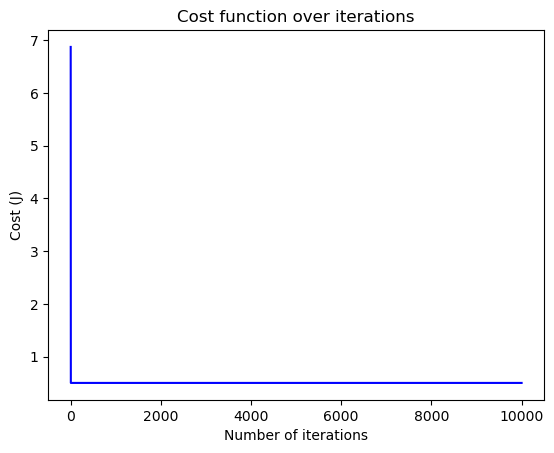

Expected outcome with zero initialized theta, alpha 0.01 and 10000 itterations:
Final cost: 0.5
Theta original: [ 0.25846249 -0.74029875 -0.00660125  0.00226283 -0.43112639]


In [105]:
# YOUR CODE HERE TO CREATE scaled_X, y and theta 
scaler = StandardScaler()

X, y, theta = data_preparation(df_logS)
X_feature = X[:, 1:]
# define X, y, theta, and scale X
### begin solution ###
X_scaled_feature = scaler.fit_transform(X_feature)
X_scaled = np.c_[np.ones((X.shape[0],1)),X_scaled_feature]
### end solution ####
print("Initial cost:", compute_cost(X_scaled, y, np.zeros(theta.shape)))

# Set hyperparameters
alpha = 0.01  # Learning rate
num_iters = 10000  # Number of iterations

theta, J_history = gradient_descent(X_scaled, y, theta, alpha, num_iters)
reverse_theta(theta, scaler)
try: 
    # Run gradient descent
    theta, J_history = gradient_descent(X_scaled, y, theta, alpha, num_iters)

    # Final parameters
    print("Theta:", theta)
    print(f"Theta original: {reverse_theta(theta, scaler)} ")

    # Final cost
    print("Final cost:", J_history[-1])
    J_history = [compute_cost(X_scaled, y, np.zeros(theta.shape))] + list(J_history)
    draw_costs(J_history)
except:
    print('something went wrong, try again')
finally: 
    print('Expected outcome with zero initialized theta, alpha 0.01 and 10000 itterations:')
    print('Final cost: 0.5')
    print('Theta original: [ 0.25846249 -0.74029875 -0.00660125  0.00226283 -0.43112639]')



#### critical note

The delaney formula differs. This should be addressed somewhere in the evaluation document

---

<a name='04'></a>
## Part D: implement regularization

Regularization works by adding the penalty term to the cost function used in linear regression. The penalty term controls the magnitude of the coefficients. The regularization term prevents the coefficients from becoming too large. 

There are three regularization methods. Lasso, Ridge and Elastic net
The ridge regression formula is 
$$ J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} ( h_\theta(x^{(i)}) - y^{(i)} ) ^2 + \lambda \sum_{j=1}^{m}\theta_j^2$$

where the regularization term is 
$$ \lambda \sum_{j=1}^{m}\theta_j^2$$ 

In gradient descent, you update the parameters $theta_j$ (except for the intercept term) by subtracting the learning rate times the gradient. The update rules are as follows:

$$\theta_j := \theta_j - \alpha \left( \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} + \frac{\lambda}{m} \theta_j \right) \quad \text{for} \; j \geq 1
$$

$$
\theta_0 := \theta_0 - \alpha \left( \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) \right)
$$



A higher value of λ increases the penalty on the coefficients, effectively shrinking them towards zero but never exactly zero, thus preventing overfitting by reducing the model complexity. A lower value of λ reduces the impact of the regularization term, allowing the model to fit the data more closely, which could lead to overfitting if the model becomes too complex. λ = 1 is considered as moderate regularization.



https://video.hanze.nl/media/regularization.m4v/0_cv10hwxn


### <span style="background-color: lightyellow;">Regularization Task</span>
- update the `compute_cost` function and `gradient_descent` function with regularization (best is to copy the function to keep the original)
- test the functions to see the effect

---

In [106]:
def compute_cost(X, y, theta, lambda_):
    # YOUR CODE HERE
    ### begin solution ####
    # 1.Determine the number of data points
    m = len(X)
    # 2.Determine the prediction 
    pred = X @ theta
    # 3.Calculate the difference between this prediction and the actual value
    err = pred - y

    # 4.square this difference
    sq_err = np.dot(err.T, err)
    # 5.Add all these squares together and divide by twice the number of data points
    cost = sq_err / (2 *m)

    reg = (lambda_ / (2*m)) * np.sum(theta[1:] **2)
    J = cost + reg
    return J
    ### end solution

def gradient_descent(X, y, theta, alpha, iter_n, lambda_):
    # YOUR CODE HERE
    ### begin solution
     
    # initialize list of costs
    cost_history = np.zeros(iter_n)
    #YOUR CODE HERE
    
    ### begin solution ####
    m = len(y)

    for i in range(iter_n):
        # Determine the prediction for the data point, given the current value of theta
        pred = X @ theta
        # Determine the difference between this forecast and the true value
        err = pred - y

        # Regularization step (theta 0 not regularized)
        reg = (lambda_ / m) * theta
        reg[0] = 0
        
        # Multiply this difference by the ith value of X + reg.
        gradient = (1/m) * X.T @ err + reg
        
        # Update the ith parameter of theta, namely by decreasing it by
        theta = theta - alpha * gradient
        cost_history[i] = compute_cost(X,y,theta)
    ### end solution
    return theta, J_history

# YOUR CODE HERE
# prepare the data 
# test the function 
# print and plot the results



# Summary Regression
By now you created code to compute the cost, the gradient_descent to update theta and you included a regularization factor. Best practise is to compose a regression class with all methods and parameters to set (learningrate, lambda, number of itterations), including some feedback methods (transfered back coefficients and cost function plot). Use a method `fit()` to create a linear regresssion model equation and `predict` to use the model. Evaluate the usage and performance of your model.  

Theta (scaled): [-3.05799738 -1.38217885 -0.6767248   0.00794796 -0.14556473]
Theta (original): [ 0.25515389 -0.74104033 -0.00659732  0.00302635 -0.42419514]
Final cost: 0.5058463900029193


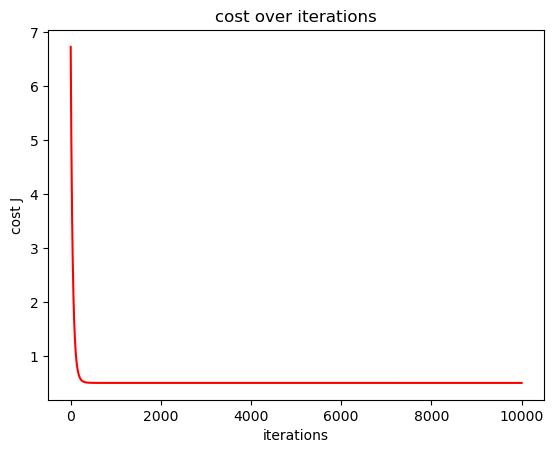

In [107]:
# YOUR CLASS HERE 
# YOUR TEST CODE HERE
from LinearRegression import LinearRegression

# Prepare data
X = df_logS.drop(columns=["logS"]).to_numpy()
y = df_logS["logS"].to_numpy()

# Train model
model = LinearRegression(alpha=0.01, iter_n=10000, lambda_=1)
model.fit(X, y)

# Show results
print("Theta (scaled):", model.theta)
print("Theta (original):", model.reverse_theta())
print("Final cost:", model.J_history[-1])

# Plot cost
model.plot_cost()

# Predict
y_pred = model.predict(X)


---
# Logistic Regression
---
<a name='051'></a>
## Part E: Use case logistic regression

The logistic regression use case in this notebook is based on data from the `ChemBL` database [2], a comprehensive resource that provides information on the bioactivity of small molecules and their biological targets. Specifically, we will focus on `CHEMBL2034`[2], which pertains to the Glucocorticoid Receptor (GR), a nuclear receptor that regulates gene expression in response to steroid hormones. The GR plays a critical role in various physiological processes, including inflammation, metabolism, and immune response.

Understanding the bioactivity of compounds targeting the GR is essential for drug discovery and the development of therapeutics aimed at modulating its activity. The CHEMBL2034 dataset includes molecular structure data (SMILES) and bioactivity data. By analyzing structure-activity relationships (SAR), researchers can understand how modifications in a molecule's structure influence its bioactivity. This knowledge is crucial for optimizing drug candidates. In this use case we will predict if the molecule developes significant bioactivity or not.  

To use the ChemBL database we can use the chembl_webresource_client API. The API fetches bioactivity data for compounds targeting the GR, filtered by IC50 values. Fields from the dataset we will work with are the `canonical_smiles` providing the molecular structure, and `standard_value` (IC50) which is used to determine bioactivity. We transfer bioactivity to 0 or 1, in order to use it as a class. The `rdkit` (rdkit.org/docs) [4] can be used to compute features from the SMILE structure. 

SMILES (Simplified Molecular Input Line Entry System): A notation that provides a way to describe a molecule's structure using a string of text

[2] Gaulton, A., et all, 2012. ChEMBL: a large-scale bioactivity database for drug discovery. Nucleic acids research, 40(D1), pp.D1100-D1107.<br></br>
[3] Landrum, G., 2013. Rdkit documentation. Release, 1(1-79), p.4.


### <span style="background-color: lightyellow;">Data preperation Task</span>

- **Review the Script:** Carefully examine the script provided below to understand how the data is featurized. There is no need to execute the code; focus on grasping the transformation and feature extraction processes involved.

- **Load the Data:** Download the `CHEMBL2034.csv` file from Blackboard and load it into this notebook.
- Conduct a thorough **inspection** of the dataset to familiarize yourself with its structure and contents. 
- **Data Cleaning:** Based on your inspections, perform the necessary data cleaning steps to ensure the dataset is ready for analysis. 


In [108]:
# ### CODE THAT WAS USED TO PREPARE THE DATA FILE 
# # imports to retrieve data from chemBL
# from chembl_webresource_client.new_client import new_client
# from rdkit import Chem
# from rdkit.Chem import Descriptors

# # Initialize the ChEMBL client
# chembl = new_client

# target_chembl_id = 'CHEMBL2034' #Glucocorticoid receptor targets

# # Get bioactivity data for the target
# activity = chembl.activity.filter(target_chembl_id=target_chembl_id, standard_type='IC50')

# # Convert to DataFrame
# import pandas as pd

# activity = "CHEMBL2034.csv"
# df_activity = pd.read_csv(activity)
# display(df_activity.head(2))
# print(df_activity.columns)
# # Select relevant columns and drop rows with missing values
# df_activity = df_activity[['molecule_chembl_id', 'canonical_smiles', 'standard_value']]
# df_activity.dropna(inplace=True)

# # Convert IC50 values to binary labels (active if IC50 < 1000 nM, inactive otherwise)
# df_activity['bioactivity_label'] = df_activity['standard_value'].apply(lambda x: 1 if float(x) < 1000 else 0)

# display(df_activity.head(2))

# # Function to calculate molecular descriptors for smiles
# def calculate_descriptors(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     descriptors = {
#         'MolecularWeight': Descriptors.MolWt(mol),
#         'NumHDonors': Descriptors.NumHDonors(mol),
#         'NumHAcceptors': Descriptors.NumHAcceptors(mol),
#         'TPSA': Descriptors.TPSA(mol)
#     }
#     return pd.Series(descriptors)

# # Calculate descriptors for each molecule
# df_descriptors = df_activity['canonical_smiles'].apply(calculate_descriptors)
# df_GR= pd.concat([df_descriptors, df_activity], axis=1)
# df_GR.drop(columns=['standard_value', 'molecule_chembl_id'], inplace=True)

# print('final dataframe')
# display(df_GR.head(2))
# df_GR.to_csv('CHEMBL2034.csv',index=False)

In [109]:
# # --- Imports ---
# from chembl_webresource_client.new_client import new_client
# from pubchempy import get_compounds
# import pandas as pd

# # --- Step 1: Retrieve bioactivity data from ChEMBL ---
# target_chembl_id = 'CHEMBL2034'  # Glucocorticoid receptor

# chembl = new_client
# activity = chembl.activity.filter(target_chembl_id=target_chembl_id, standard_type='IC50')

# # Convert to DataFrame
# df_activity = pd.DataFrame(activity)
# print("Columns retrieved from ChEMBL:", df_activity.columns.tolist())

# # --- Step 2: Keep only relevant columns ---
# df_activity = df_activity[['molecule_chembl_id', 'canonical_smiles', 'standard_value']]
# df_activity.dropna(inplace=True)

# # --- Step 3: Convert IC50 to binary bioactivity labels ---
# # Active = 1 if IC50 < 1000 nM, else 0
# df_activity['bioactivity_label'] = df_activity['standard_value'].astype(float).apply(lambda x: 1 if x < 1000 else 0)

# print("Sample bioactivity data:")
# display(df_activity.head(2))

# # --- Step 4: Compute molecular descriptors using PubChem ---
# def calculate_descriptors_pubchem(smiles):
#     """
#     Given a SMILES string, fetch basic molecular descriptors from PubChem.
#     Returns NaN if compound retrieval fails.
#     """
#     try:
#         compound = get_compounds(smiles, namespace='smiles')[0]
#         descriptors = {
#             'MolecularWeight': compound.molecular_weight,
#             'NumHDonors': compound.h_bond_donor_count,
#             'NumHAcceptors': compound.h_bond_acceptor_count,
#             'TPSA': compound.tpsa
#         }
#         return pd.Series(descriptors)
#     except Exception as e:
#         print(f"⚠️ Could not fetch data for SMILES: {smiles} ({e})")
#         return pd.Series({'MolecularWeight': None, 'NumHDonors': None, 'NumHAcceptors': None, 'TPSA': None})

# print("Fetching descriptors from PubChem (this may take a while)...")

# df_descriptors = df_activity['canonical_smiles'].apply(calculate_descriptors_pubchem)

# # --- Step 5: Combine descriptors with bioactivity data ---
# df_GR = pd.concat([df_descriptors, df_activity], axis=1)
# df_GR.drop(columns=['standard_value', 'molecule_chembl_id'], inplace=True)

# print("✅ Final dataframe:")
# display(df_GR.head(5))

# # --- Step 6: Save prepared dataset ---
# df_GR.to_csv('CHEMBL2034_test.csv', index=False)
# print("📁 Saved cleaned dataset to CHEMBL2034_test.csv")


In [110]:
import pandas as pd
df_GR = pd.read_csv('CHEMBL2034.csv')

---

<a name='05'></a>
## Part F: implement logistic regression

Logistic regression uses the logistic function (sigmoid function) to map predicted values to probabilities. The logistic function is defined as:

$$ g (z) = \frac {1} {1 + e ^ {- z}} $$

where $z$ is the linear combination of the input features, similar to linear regression
$$z = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n$$



The terms (intercept and coefficients) are also calculated with a `compute_cost` function and `gradient_descent` function, but the coefficients are calculated differently. In logistic regression, coefficients represent the log odds. Positive coefficients increase the log odds of the outcome being 1, while negative coefficients decrease the log odds. 

The cost function is computed as:

$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(h_\theta(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \right] + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_j^2 
$$

in python
```{python}
h = sigmoid(X.dot(theta))
cost = -1 / m * (y.dot(np.log(h)) + (1 - y).dot(np.log(1 - h)))
```


and the gradient descent is computed for the intercept term ($\theta_0$):

  $$
  \theta_0 := \theta_0 - \alpha \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})
  $$

and for the other parameters ($\theta_j$ where $j \geq 1$) (including regularization):

  $$
  \theta_j := \theta_j - \alpha \cdot \left( \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} + \frac{\lambda}{m} \theta_j \right)
  $$

where $h$ again is the result of the sigmoid function. The gradients for logistic regression and regression are similar, but the prediction $h_\theta(x^{(i)})$ is the output of the sigmoid function rather than a linear output. Basically it is a probability rather than a direct numeric prediction.

The output of logistic regression can be interpreted as the probability of the target variable being 1. This probability can be converted into a binary decision by setting a threshold 
Commonly, a threshold of 0.5 is used, where:
- If $P(y=1|x) \geq 0.5$, classify as 1.
- If $P(y=1|x) < 0.5$, classify as 0.

### <span style="background-color: lightyellow;">Logistic regression Task</span>

- Implement the `sigmoid` function in the cell below. Make it so that you can add both a number and a vector to it. In the first case, the function must return the sigmoid value of the number, in the second case it must return a vector containing the sigmoid value of each individual element in the input vector. You can use the numpy function `exp()`.
- Complete `compute_cost` and `gradient_descent` function for logistic regression
- Complete the `predict` function. 
- Test your code 


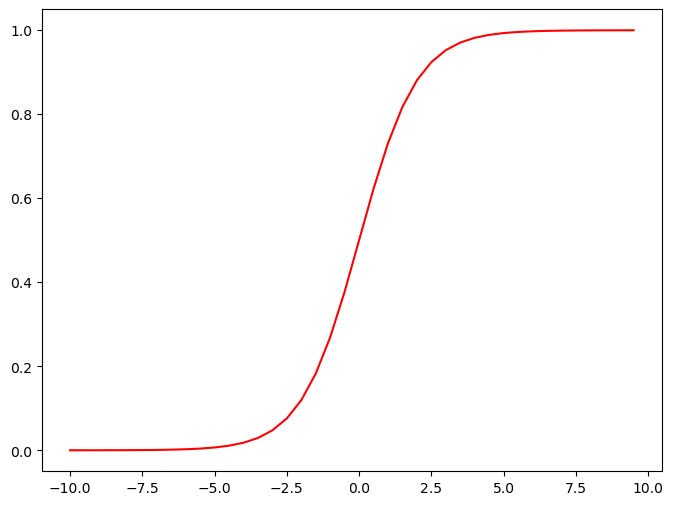

In [111]:
def sigmoid(z):
    return  1 / (1 + np.exp(-z))

#code to validate function
try:    
    nums = np.arange(-10, 10, step=.5)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(nums, sigmoid(nums), 'r')
except:
    print('make sure that the sigmoid function returns the sigmod')

Now we can use the sigmoid function in the other functions. Complete the functions below

In [112]:
def compute_cost(X, y, theta, lambda_):
    """
    Compute cost for logistic regression with regularization.

    Parameters:
    X:  Input feature matrix (m x n)
    y: True labels vector (m,)
    theta: Parameters vector (n,)
    lambda_: Regularization parameter

    Return:
    J:Cost value
    """
    # YOUR CODE HERE
    ### begin solution ###
    # Number of training samples:
    m = len(y)

    #compute linear combination
    pred = X @ theta

    # apply sigmoid to get prediction
    sigma = sigmoid(pred)

    #compute main cost
    term1 = -y * np.log(pred)
    term2 = (1-y) * np.log(1-sigma)
    no_reg_cost = np.sum(term1 - term2) / m

    # compute regularization
    theta_ex_bias = theta[1:]
    reg_term = (lambda_ / (2*m)) * np.sum(theta_ex_bias ** 2)

    #total cost
    total_cost = reg_term + no_reg_cost
    ### end solution ####
    return total_cost


def gradient_descent(X, y, theta, alpha, iter_n, lambda_):
    """
    Perform gradient descent to find optimal theta.

    Parameters:
    X: Input feature matrix (m x n)
    y: True labels vector (m,)
    theta: Initial parameters vector (n,)
    alpha: Learning rate
    num_iters: Number of iterations
    lambda_:  Regularization parameter

    Return:
    theta:  Updated parameters vector
    J_history:  History of cost values
    """
    # YOUR CODE HERE
   # initialize list of costs
    cost_history = np.zeros(iter_n)
    #YOUR CODE HERE
    
    ### begin solution ####
    m = len(y)

    for i in range(iter_n):
        # Determine the prediction for the data point, given the current value of theta
        pred = X @ theta

        sigma = sigmoid(pred)
        
        # Determine the difference between this forecast and the true value
        err = sigma - y

        gradient = (X.T @ err) / m
        
        # Regularization step (theta 0 not regularized)
        reg = (lambda_ / m) * theta
        reg[0] = 0 
        gradient_reg = gradient + reg
        
        
        # Update the ith parameter of theta, namely by decreasing it by
        theta = theta - alpha * gradient_reg
        
        cost_history[i] = compute_cost(X,y,theta, lambda_)
    ### end solution
    return theta, J_history

#BONUS
def predict_proba(X, theta):
    pred = X @ theta
    prob = 1/(1+np.exp(-pred))
    return pred, prob

def predict(X, theta, threshold=0.5):
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters theta.

    Parameters:
    X: Input feature matrix (m x n)
    theta: Parameters vector (n,) (computed by compute cost and gradient descentl)
    threshold: Threshold for prediction

    Return:
    p: Predicted labels vector (m,)
    """
    # YOUR CODE HERE
    pred, prob = predict_proba(X, theta)
    # pred = (prob >= threshold).astype(int) part generated with chatgpt code since i couldnt figure out my error. When i tried to make an if else statement of it.
    pred = (prob >= threshold).astype(int)
    return pred

    


In [113]:
data = df_GR
display(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3401 entries, 0 to 3400
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MolecularWeight    3401 non-null   float64
 1   NumHDonors         3401 non-null   float64
 2   NumHAcceptors      3401 non-null   float64
 3   TPSA               3401 non-null   float64
 4   canonical_smiles   3401 non-null   object 
 5   bioactivity_label  3401 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 159.6+ KB


None

/tmp/ipykernel_2998/1427322794.py:26: RuntimeWarning: invalid value encountered in log
  term1 = -y * np.log(pred)


0.8056453984122317


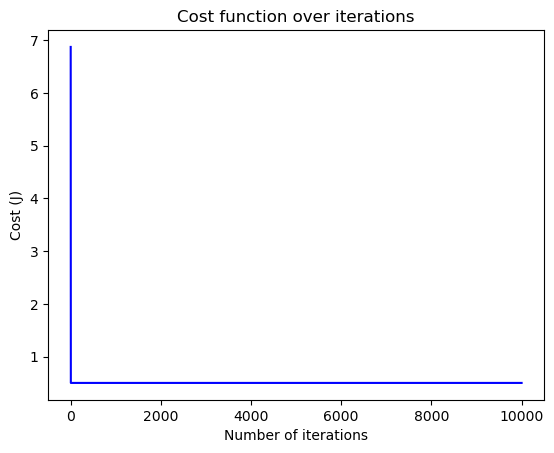

error:0.5048011505741755
Depending on hyperparameters accuracy should be around 0.75 +/- 1


In [114]:
#YOUR CODE HERE TO PREPARE X_scaled, y, theta

y = df_GR['bioactivity_label'].values.reshape(-1, 1)
X = df_GR[['MolecularWeight', 'NumHDonors', 'NumHAcceptors', 'TPSA']].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add a column of ones to X for the intercept term (bias)
X_scaled = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled]

# Initialize theta (parameters), alpha (learning rate), and iterations
theta = np.zeros((X_scaled.shape[1], 1))
# Set hyperparameters, adjust to imporve
alpha = 0.01  # Learning rate
iter_n = 15000  # Number of iterations
lambda_ = 0.7  # Regularization parameter


try: 
    # Train the model
    theta, J_history = gradient_descent(X_scaled, y, theta, alpha, num_iters, lambda_)

    # Make predictions
    predictions = predict(X_scaled, theta)

    # Evaluate the model
    acc = accuracy(y, predictions)


    draw_costs(J_history)
    print(f'error:{J_history[-1]}')
except: 
    print('something is wrong')
finally:
    print('Depending on hyperparameters accuracy should be around 0.75 +/- 1')


<a name='06'></a>
## Part G: compare with sklearn

Scikit-Learn, often referred to as sklearn, is a powerful and widely-used open-source machine learning library for Python. It contains regression models as well. 
See https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html and 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


### <span style="background-color: lightyellow;">Evaluation Task</span>
Compare the performance (error) and coefficients (theta values) of your regression model to the error and coefficients of the sklearn regression model. 

Next compare the performance  of your logistic regression model to your own developed model. As a minimum compare accuracy.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

### Notes: 
Best practise is to split your data into a train set and test set. <br></br>
The models differ from the original delaney paper. Can you think of any reason? 



I used chatgpt for the sklearn 


In [118]:
# YOUR CODE HERE TO EVALUATE REGRESSION MODEL
# expected outcome is that both models should procude similar outcomes

### begin solution

from sklearn.model_selection import train_test_split

# Features and target
X = df_GR[['MolecularWeight', 'NumHDonors', 'NumHAcceptors', 'TPSA']].values
y = df_GR['bioactivity_label'].values

# X, y, theta = data_preparation(df_GR)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### end solution

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add bias column for intercept
X_train_scaled = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_scaled = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]


In [119]:
# YOUR CODE HERE TO EVALUATE LOGISTIC REGRESSION MODEL

### begin solution

# Initialize theta
theta = np.zeros(X_train_scaled.shape[1])

# Train using gradient descent (assume gradient_descent_logistic exists)
theta, J_history = gradient_descent(X_train_scaled, y_train, theta, alpha=0.01, iter_n=10000, lambda_=1)

# Predict on test set
y_pred_custom = predict(X_test_scaled, theta)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create sklearn model (L2 regularization by default)
sk_model = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=10000)
sk_model.fit(X_train_scaled[:,1:], y_train)  # skip the bias column; sklearn handles it internally

# Predict on test set
y_pred_sklearn = sk_model.predict(X_test_scaled[:,1:])


# Custom model
acc_custom = accuracy_score(y_test, y_pred_custom)
# sklearn model
acc_sklearn = accuracy_score(y_test, y_pred_sklearn)

print(f"Custom logistic regression accuracy: {acc_custom:.3f}")
print(f"Sklearn logistic regression accuracy: {acc_sklearn:.3f}")

# Custom model (scale back if needed)
theta_original = reverse_theta(theta, scaler)  # if you implemented reverse_theta

print("Custom model coefficients (original scale):", theta_original)

# Sklearn coefficients
print("Sklearn model coefficients:", sk_model.coef_)

### end solution

/tmp/ipykernel_2998/1427322794.py:26: RuntimeWarning: invalid value encountered in log
  term1 = -y * np.log(pred)


Custom logistic regression accuracy: 0.805
Sklearn logistic regression accuracy: 0.805
Custom model coefficients (original scale): [-3.34378882  0.00886567  1.08833129  0.40909009 -0.04085515]
Sklearn model coefficients: [[ 1.05623682  1.59880503  1.59006216 -2.2692172 ]]


<a name='07'></a>
## Part H: Development of the logistic regression class

When you are satisfied with your developed code snippets you can build a python file (No notebook!!!) with the logistic regression class. Use your Object Oriented programming skills to compose a class with at least the methods `fit()` and `predict()`.  The method `fit()` should fit the best logistic regression equation and the method `predict()` should predict the class. Add the `predict_proba()` method optionally . 

### <span style="background-color: lightyellow;">Development Task</span>
Submit a repository with a directory `regression` that includes:
- The logistic regression class (python file) with proper documentation.
- This completed notebook for reference
- An evaluation document that details specific scenarios or datasets where each type of regression (linear, logistic, polynomial) is appropriate or inappropriate.

### Additional notes
- Code quality and readability are important, so adhere to best practices in coding and documentation.
- If you want to optimize your model you could consider the deepchem featurizer (not mandatory, just for fun)
- use an argumentative approach in your notebook



Accuracy: 1.0


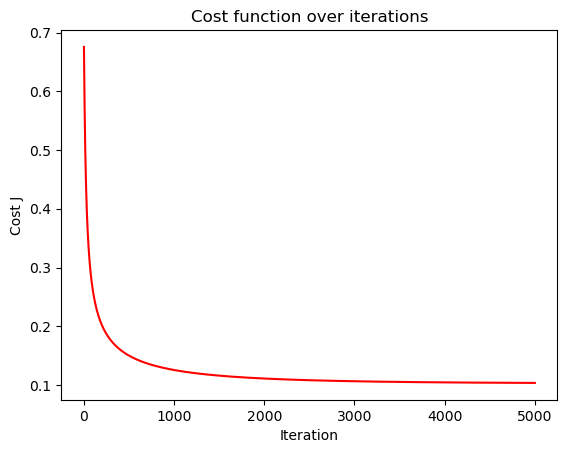

In [117]:
from LogisticRegression import LogisticRegression
import numpy as np

# Sample data
np.random.seed(42)
X = np.random.randn(100, 2)
y = (X[:,0] + X[:,1] > 0).astype(int).reshape(-1,1)

# Fit model
model = LogisticRegression(alpha=0.1, iter_n=5000, lambda_=0.1)
model.fit(X, y)

# Predict
y_pred = model.predict(X)
accuracy = np.mean(y_pred == y)
print("Accuracy:", accuracy)

# Plot cost
model.plot_cost()


<a name='08'></a>
## Part I: Development of the polynomial regression class

This part is the bonus part, and it is not mandatory. 

Make sure that you understand the theoretical background of the polynomial regression. 
In addition to the logistic regression develop your own polynomial regression class. Demonstrate the performance and usage with a use case. 



---

## References:
- Numpy: https://nbviewer.jupyter.org/github/ageron/handson-ml/blob/master/tools_numpy.ipynb
- Linear regression: https://video.hanze.nl/media/linear+regression/0_63duegik
- vectorized implementation: https://video.hanze.nl/media/why_we_love_numpy.mov/0_npz2lx0a
- gradient descent: https://video.hanze.nl/media/gradient_descent/0_otuqf7wj
- regularization https://video.hanze.nl/media/regularization.m4v/0_cv10hwxn

[1]. Delaney, John S. “ESOL: estimating aqueous solubility directly from molecular structure.” Journal of chemical information and computer sciences 44.3 (2004): 1000-1005.<br></br>
[2] Gaulton, A., et all, 2012. ChEMBL: a large-scale bioactivity database for drug discovery. Nucleic acids research, 40(D1), pp.D1100-D1107.<br></br>
[3] Landrum, G., 2013. Rdkit documentation. Release, 1(1-79), p.4.

